In [382]:
import numpy as np
from prettytable import PrettyTable
import os
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors as colors
import matplotlib.ticker
import scipy.signal
import scipy.optimize as op
import plasmapy
import matplotlib.cm as cm
from scipy import special as sp
from scipy import integrate
from prettytable import PrettyTable
from scipy import fftpack
from tqdm import tqdm
%config InlineBackend.figure_format = 'svg'

# Simulation of $sech^4$ type electron hole

## Theory
- Schamel distribution
$$ f_e (v^2>2\phi) = \exp \left[ -\frac{\left(\sqrt{v^2-2\phi}+u\right)^2}{2} \right] $$
$$ f_e (v^2<2\phi) = \exp \left[ -\beta \left(\frac{v^2}{2}-\phi\right) - \frac{u^2}{2} \right] $$
其中$v$为孤波参考系中的速度，静系速度$v_0=v+u$
- 此分布下存在孤波
$$ \phi = \psi sech^4\left[\frac{x-u t}{4}\right]$$
- nonlinear dispersion relation
$$ 1+uZ(u) = -\frac{1}{2}Z'_r(u) = \frac{16}{15}b\sqrt{\psi}$$
- density distribution
$$n_e = 1 + \frac{d^2 \phi}{d x^2} = \psi\left[ sech^4(\frac{x-ut}{4})tanh^2(\frac{x-ut}{4}) -\frac{1}{4} sech^6(\frac{x-ut}{4}) \right]$$

In [472]:
def nonvec_f(vv,x):
    r = 0
    if vv<=u-np.sqrt(2*phi_theo(x)):
        r=np.exp(-(np.sqrt((vv-u)**2-2*phi_theo(x))+u)**2/2) 
    elif vv>=u+np.sqrt(2*phi_theo(x)):
        r=np.exp(-(-np.sqrt((vv-u)**2-2*phi_theo(x))+u)**2/2) 
    else:
        r = np.exp(-beta*((vv-u)**2/2-phi_theo(x))-u**2/2) 
    return r/np.sqrt(np.pi)
ff = np.vectorize(nonvec_f)
def psi_cal(u):
    r1 = 1+u*plasmapy.dispersion.plasma_dispersion_func(u).real
    b = np.exp(-u**2)*(1-beta-2*u**2)/np.sqrt(np.pi)
    return (r1*15/16/b)**2
def phi_theo(x):
    return d*np.exp(-(x-L/2)**2/dd)

In [920]:
u = 0.8
dd = 0.2
d = 0.5
beta = -0.0
psi = psi_cal(u)
v = np.linspace(-5,5,num=200)
print(psi)

2.7985220446373926


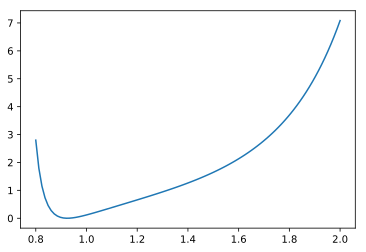

In [924]:
ulist = np.linspace(0.8,2,num=100)
plt.plot(ulist,psi_cal(ulist))

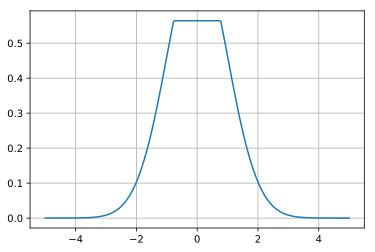

In [478]:
plt.plot(v,ff(v,L/2))
plt.grid()
plt.show()

In [966]:
T = 1
k = 0.1
L = 2*np.pi/k

vmax = 8 # 速度最大值
nx = 500
nv = 800
dx = L/(nx-1)
dv = 2*vmax/(nv-1)
x = np.linspace(0, L, num=nx, endpoint=True)
v = np.linspace(-vmax, vmax, num=nv, endpoint=True)
V,X=np.meshgrid(v,x)
dt = 0.005
max_steps  = 10000
data_steps = max_steps
data_num = int(max_steps/data_steps)+1
d = 0.3
linear_time = 2*np.pi/np.sqrt(d)

path = '../data/'
print(data_num)
print('k=',k)
print('limited time=',2*np.pi/k/dv)
print('real time = ', max_steps*dt)
print('linear time=',linear_time)

2
k= 0.1
limited time= 3137.6656627728057
real time =  50.0
linear time= 11.471474419090953


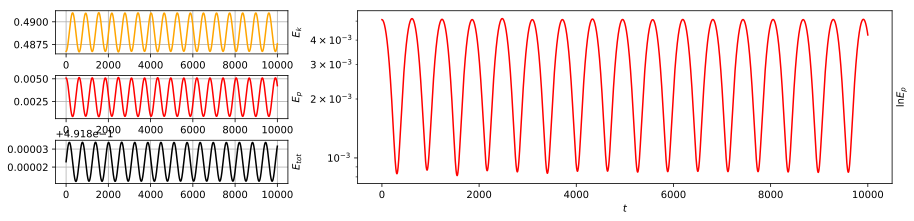

In [967]:
dataet = np.loadtxt(os.path.join(path,"tot_energy"))[0:max_steps]
dataep = np.loadtxt(os.path.join(path,"pot_energy"))[0:max_steps]
dataek = np.loadtxt(os.path.join(path,"kin_energy"))[0:max_steps]

t = np.linspace(0, max_steps, max_steps)
fig = plt.figure(figsize=(15, 3))

ax1 = plt.subplot2grid((3, 3), (0, 0))
ax1.plot(t, dataek, color='orange')
ax1.grid()
ax1.set_ylabel(r'$E_k$')
ax1.yaxis.set_label_position("right")

ax2 = plt.subplot2grid((3, 3), (1, 0))
ax2.plot(t, dataep, color='r')
ax2.grid()
ax2.set_ylabel(r'$E_p$')
ax2.yaxis.set_label_position("right")

ax3 = plt.subplot2grid((3, 3), (2, 0))
ax3.plot(t, dataet, color='black')
ax3.grid()
ax3.set_ylabel(r'$E_{tot}$')
ax3.yaxis.set_label_position("right")

axl2 = plt.subplot2grid((3, 3), (0, 1),colspan=2, rowspan=3)
axl2.plot(t, dataep, color='r')
axl2.set_ylabel(r'$\ln E_p$')
axl2.set_yscale('log')
axl2.yaxis.set_label_position("right")

fig.subplots_adjust(bottom=0.1, top=0.9, hspace=.5, wspace=.3)
plt.xlabel(r'$t$')
plt.show()

In [968]:
progesses = np.arange(0,data_num,1)

f = []
phi = []

for progess in progesses:
    f_temp = np.loadtxt(os.path.join(path,"data"+str(progess)))
    f.append(f_temp)
    phi_temp = np.loadtxt(os.path.join(path,"phi"+str(progess)))
    phi.append(phi_temp)

In [969]:
fx0 = np.sum(f[0],axis=1)*dv
fv0 = np.sum(f[0],axis=0)*dx/L
fx = np.sum(f[data_num-1],axis=1)*dv
fv = np.sum(f[data_num-1],axis=0)*dx/L

In [972]:
fig = plt.figure(figsize=(10, 8))

test_frame = 1
Z = f[test_frame]
fv = np.sum(Z, axis=0)*dx/L
Z_phi = phi[test_frame]
# Z[np.where(Z<1e-8)]=0
lvs_idx = np.linspace(-15,1,num=50)
lvs = 10**lvs_idx

ax1 = plt.subplot2grid((2, 2), (0, 0))
ax1cm = ax1.contourf(X, V, Z, levels=lvs,norm=colors.LogNorm(vmin=lvs.min(),vmax=lvs.max()),cmap=cm.plasma)
ax1.set_xlabel(r'$x$')
ax1.set_ylabel(r'$v$')
# ax1.set_ylim(2,5)

ax2 = plt.subplot2grid((2, 2), (0, 1))
ax2.plot(v, fv, color='red')
ax2.plot(v, fv0,'--', color='blue')
ax2.set_xlabel(r'$v$')
ax2.set_ylabel(r'$f_{v}$')
ax2.set_yscale('log')
ax2.grid()

ax3 = plt.subplot2grid((2, 2), (1, 0))
ax3.plot(x, fx, color='red')
ax3.plot(x, fx0,'--', color='blue')
ax2.set_xlabel(r'$v$')
ax3.set_xlabel(r'$x$')
ax3.set_ylabel(r'$fx$')
ax3.grid()

ax4 = plt.subplot2grid((2, 2), (1, 1))
ax4.plot(x, Z_phi, color='red')
ax4.plot(x, phi[0],'--', color='blue')
ax4.set_xlabel(r'$x$')
ax4.set_ylabel(r'$\phi$')
ax4.grid()

title_text = "L= " + str(round(L,2)) + r"$; k= $" + str(k) + r"$; u= $" + str(u) + r"$; \Delta= $" + str(d) + "; Time= " + str(int(dt*max_steps))
fig.suptitle(title_text, va='bottom')
plt.tight_layout()

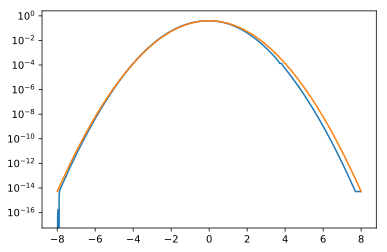

In [957]:
plt.plot(v,f[1][250])
plt.plot(v,f[0][0])
plt.yscale('log')
plt.show()

In [975]:
np.sum(fx0)*dx/L

1.0020283959267384